In [44]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

# WHO - global influenza occurences
The WHO reports Influenza occurences for all around the world on a weekly basis. It is expected that due to spreading patterns of influenza waves throughout the world, influenza waves different countries can be used as an indicator for the prediction of influenza waves for Germany. The data for the **Influenza transmission zone** South West Europe is analysed below 

Note: The influenza transmission zones join geographically related countries or territories to larger areas that have similar influenza transmission patterns so that an overview can be given. www.who.int/csr/.../swineflu/Influenza_Transmission_Zones.pdf


In [45]:
df_who_global = pd.read_csv('FluNetInteractiveReport.csv',skiprows=3,parse_dates=['SDATE','EDATE']).fillna(value = 0)
df_who_global.head()


,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
0,Albania,European Region of WHO,South West Europe,1997,1,1996-12-30,1997-01-05,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report
1,Albania,European Region of WHO,South West Europe,1997,3,1997-01-13,1997-01-19,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report
2,Albania,European Region of WHO,South West Europe,1997,16,1997-04-14,1997-04-20,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report
3,Albania,European Region of WHO,South West Europe,1998,5,1998-01-26,1998-02-01,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report
4,Albania,European Region of WHO,South West Europe,1998,6,1998-02-02,1998-02-08,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report


['Country', 'WHOREGION', 'FLUREGION', 'Year', 'Week', 'SDATE', 'EDATE', 'SPEC_RECEIVED_NB', 'SPEC_PROCESSED_NB', 'AH1', 'AH1N12009', 'AH3', 'AH5', 'ANOTSUBTYPED', 'INF_A', 'BYAMAGATA', 'BVICTORIA', 'BNOTDETERMINED', 'INF_B', 'ALL_INF', 'ALL_INF2', 'TITLE']


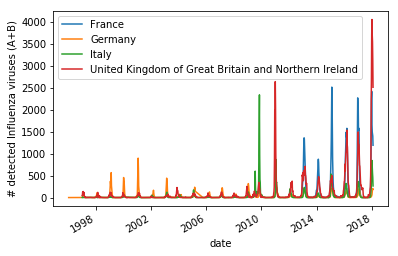

In [46]:
print(list(df_who_global))

start_date_plot='1995-11-01'
end_date_plot='2018-06-03'

df_2years_G_F_I = df_who_global.loc[df_who_global['Country'].isin(['United Kingdom of Great Britain and Northern Ireland','Germany','Italy','France'])&(df_who_global['SDATE']>=start_date_plot)&(df_who_global['EDATE']<=end_date_plot)]

df_2years_G_F_I.set_index('SDATE',inplace=True)
fig = plt.figure()
df_2years_G_F_I.groupby('Country')['ALL_INF'].plot(legend = True)

plt.xlabel('date')
plt.ylabel('# detected Influenza viruses (A+B)')

#plt.savefig('InfluenzaDetectionsOverTime_France_Germany_Italy.eps')


In [47]:
df_inf_per_state_full=df_who_global.pivot(index='EDATE', columns='Country', values='ALL_INF')
df_inf_per_state_full.rename(columns={'United Kingdom of Great Britain and Northern Ireland':'UK'}, inplace=True)

df_inf_per_state_full.index = pd.to_datetime(df_inf_per_state_full.index)

print(list(df_inf_per_state_full))
df_inf_per_state_full.tail()

['Albania', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Kazakhstan', 'Kosovo (in accordance with Security Council resolution 1244 (1999))', 'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Republic of Moldova', 'Romania', 'Russian Federation', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Tajikistan', 'The former Yugoslav Republic of Macedonia', 'Turkey', 'Turkmenistan', 'Ukraine', 'UK', 'Uzbekistan']


Country,Albania,Armenia,Austria,Azerbaijan,Belarus,Belgium,Bosnia and Herzegovina,Bulgaria,Croatia,Cyprus,...,Spain,Sweden,Switzerland,Tajikistan,The former Yugoslav Republic of Macedonia,Turkey,Turkmenistan,Ukraine,UK,Uzbekistan
EDATE,,,,,,,,,,,,,,,,,,,,,
2018-01-21,35.0,19.0,482.0,NaN,0.0,8.0,NaN,97.0,195.0,8.0,...,1400.0,747.0,1017.0,0.0,1.0,224.0,NaN,9.0,3695.0,2.0
2018-01-28,47.0,18.0,650.0,0.0,0.0,36.0,NaN,123.0,201.0,4.0,...,1192.0,1116.0,1039.0,3.0,8.0,210.0,NaN,25.0,3542.0,2.0
2018-02-04,82.0,21.0,667.0,3.0,6.0,14.0,NaN,54.0,215.0,NaN,...,821.0,1522.0,598.0,1.0,13.0,100.0,NaN,37.0,3119.0,1.0
2018-02-11,71.0,24.0,742.0,11.0,11.0,NaN,NaN,39.0,199.0,NaN,...,738.0,1779.0,74.0,NaN,51.0,120.0,NaN,82.0,2508.0,3.0
2018-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## RKI - Influenza occurances in Germany

In this section, the data from Robert Koch Institute about activity of Influenza virus in Germany is analysed (https://survstat.rki.de/Content/Query/Create.aspx). The data are published on weekly basis from year 2001. Every year, samples from patients with influenza-like illness are investigated, which are sent by the sentinel network of general practitioners and paediatricians. Only direct detection of influenza virus is notifiable to RKI.

In [48]:
df_RKI_states = pd.read_csv('RKI_INV_0418_season_comma.csv', sep=';',skiprows=1).fillna(value = 0)
df_RKI_states.set_index('enddate',inplace=True)
df_RKI_states.index = pd.to_datetime(df_RKI_states.index)
df_RKI_states['Germany_sum'] = df_RKI_states['Germany_sum'].astype(float)
#print(type(df_RKI_states.loc['2001-01-14','Bavaria']))
df_RKI_states=df_RKI_states.drop(['Season year and week (40)'], axis=1)
df_RKI_states

,Germany_sum,Baden-Wuerttemberg,Bavaria,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Mecklenburg-Vorpommern,Lower Saxony,North Rhine-Westphalia,Rhineland-Palatinate,Saarland,Saxony,Saxony-Anhalt,Schleswig-Holstein,Thuringia,Unknown
enddate,,,,,,,,,,,,,,,,,,
2001-01-07,7.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2001-01-14,15.0,0.0,0.0,1.0,2.0,0.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2001-01-21,55.0,1.0,4.0,0.0,10.0,0.0,0.0,0.0,6.0,2.0,9.0,2.0,0.0,13.0,2.0,3.0,3.0,0.0
2001-01-28,187.0,27.0,7.0,0.0,14.0,0.0,1.0,0.0,22.0,13.0,21.0,3.0,0.0,65.0,0.0,10.0,4.0,0.0
2001-02-04,460.0,63.0,32.0,59.0,40.0,0.0,3.0,7.0,24.0,42.0,13.0,4.0,0.0,138.0,17.0,2.0,16.0,0.0
2001-02-11,536.0,86.0,40.0,28.0,34.0,0.0,2.0,9.0,2.0,26.0,19.0,14.0,5.0,69.0,155.0,6.0,41.0,0.0
2001-02-18,405.0,64.0,61.0,23.0,16.0,0.0,1.0,10.0,7.0,31.0,12.0,34.0,2.0,74.0,45.0,10.0,15.0,0.0
2001-02-25,244.0,46.0,56.0,7.0,13.0,0.0,2.0,2.0,2.0,17.0,10.0,17.0,2.0,28.0,23.0,12.0,7.0,0.0
2001-03-04,234.0,20.0,35.0,5.0,5.0,0.0,0.0,14.0,0.0,2.0,6.0,45.0,0.0,24.0,6.0,11.0,61.0,0.0


Comparing RKI data with WHO data for Germany:

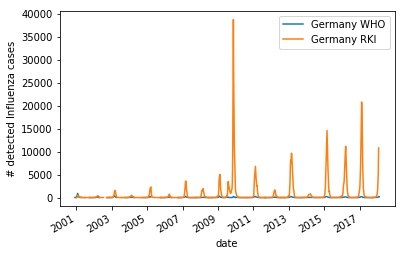

In [49]:
start_date_plot=datetime.datetime(2000,12,1)
end_date_plot=datetime.datetime(2018,3,23)

WHO_RKI=pd.DataFrame()
WHO_RKI['Germany WHO'] = df_inf_per_state_full.loc[start_date_plot:end_date_plot,'Germany']
#WHO_RKI['France WHO'] = df_inf_per_state_full.loc[start_date_plot:end_date_plot,'France']

WHO_RKI['Germany RKI']=df_RKI_states.loc[start_date_plot:end_date_plot,'Germany_sum']

WHO_RKI.plot()
plt.xlabel('date')
plt.ylabel('# detected Influenza cases')


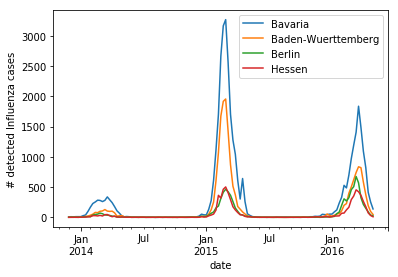

In [50]:
start_date_plot=datetime.datetime(2013,12,1)
end_date_plot=datetime.datetime(2016,5,4)

df_RKI_states.loc[start_date_plot:end_date_plot].plot(y=['Bavaria', 'Baden-Wuerttemberg', 'Berlin','Hessen'])
plt.xlabel('date')
plt.ylabel('# detected Influenza cases')
plt.legend()
plt.show()

RKI additionally provides estimates of excess-doctor visits (Exzess-Konsultationen), excess hospitalisations (Exzess-Hospitalisierungen) and other summary statistics that can be associated with the influenza wave for each season within the Influenza season reports (https://influenza.rki.de/Saisonbericht.aspx).

In [51]:
RKI_season_summary = pd.read_excel('RKI-Seasonal_reports_summary.xlsx',skiprows=1).fillna(value = 0)
RKI_season_summary

,Season,begin_w,begin_y,end_w,end_y,peak_w,peak_y,peak_date,Exzess-Konsultationen,Exzess-Arbeitsunfaehigkeiten bzw. Pflegebeduerftigkeit bei Kindern und nicht Berufstaetigen,Exzess-Hospitalisierungen,Erkrankungen (aggregiert uebermittelte Faelle und Einzelfaelle):,Erkrankungen (Einzelfaelle),Hospitalisierungen,Todesfaelle,Todesfaelle with inf,Note
0,2002/03,0.0,0.0,0.0,2003,11,2003,2003-03-13,4835000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,strong
1,2003/04,0.0,0.0,0.0,2004,1,2004,2004-01-01,1445000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,weak
2,2004/05,0.0,0.0,0.0,2005,7,2005,2005-02-17,5965000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,strong
3,2005/06,0.0,0.0,0.0,2006,52,2005,2005-12-29,1030000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,weak
4,2006/07,0.0,0.0,0.0,2007,9,2007,2007-03-01,3000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,middle
5,2007/08,0.0,0.0,0.0,2008,7,2008,2008-02-14,1355000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,weak
6,2008/09,0.0,0.0,0.0,2009,5,2009,2009-01-29,4255000,1687000.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,2009/10,42.0,2009.0,2.0,2010,46,2009,2009-11-13,2930000,1547000.0,5300.0,225729.0,172449.0,7882.0,250.0,0.0,Influenzapandemie A(H1N1)pdm09
8,2010/11,50.0,2010.0,14.0,2011,6,2011,2011-02-10,2100000,1200000.0,4700.0,0.0,41000.0,6000.0,160.0,0.0,0
9,2011/12,6.0,2012.0,16.0,2012,9,2012,2012-03-01,2100000,1100000.0,7400.0,0.0,9500.0,1800.0,0.0,26.0,0


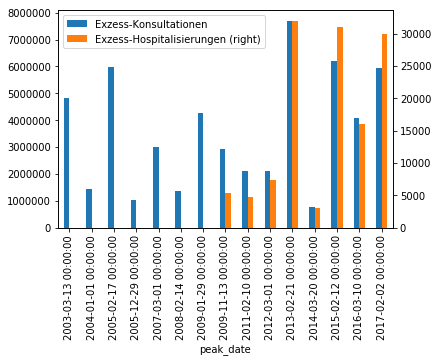

In [52]:
RKI_season_plot=RKI_season_summary.loc[:,['peak_date','Exzess-Konsultationen', 'Exzess-Hospitalisierungen']]
RKI_season_plot.set_index('peak_date',inplace=True)

RKI_season_plot.plot.bar(secondary_y=['Exzess-Hospitalisierungen'])

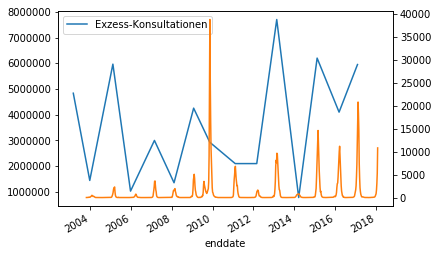

In [41]:
##just temporaty plot- will be improved: count the seasonal sum from df_RKI_states, 
# plot together with seasonal summary (RKI_season_summary) and calculate the ratio

start_date_plot=datetime.datetime(2003,11,1)
end_date_plot=datetime.datetime(2018,3,23)

RKI_season_plot2=RKI_season_summary.loc[:,['peak_date','Exzess-Konsultationen']]
RKI_season_plot2.set_index('peak_date',inplace=True)

RKI_week_plot=df_RKI_states.loc[start_date_plot:end_date_plot,'Germany_sum']

ax = RKI_season_plot2.plot()
RKI_week_plot.plot(ax=ax, secondary_y=['Germany_sum'])


#https://stackoverflow.com/questions/23482201/plot-pandas-dataframe-as-bar-and-line-on-the-same-one-chart?lq=1

## Weather data

Wheather data from Deutscher Wetterdienst (DWD) available at (ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/daily/kl/historical/)

## Cross-correlation of influenza cases reported from European countries


In the following, the cross-correlation of the influenza cases reported in Germany and in other European countries is investigated for different time-lags, that may indicate the delay of the flu wave between the countries. 



In [42]:
#settings:

#time lags (in weeks) for calculating the cross-correlation
timelag=range(-5,10,1)

#cutoff year (from which year the analysis should be done)
cutoff=datetime.datetime(2008,1,1)
df_inf_per_state=df_inf_per_state_full.loc[cutoff:]
df_inf_per_state.head()

Country,Albania,Armenia,Austria,Azerbaijan,Belarus,Belgium,Bosnia and Herzegovina,Bulgaria,Croatia,Cyprus,...,Spain,Sweden,Switzerland,Tajikistan,The former Yugoslav Republic of Macedonia,Turkey,Turkmenistan,Ukraine,UK,Uzbekistan
EDATE,,,,,,,,,,,,,,,,,,,,,
2008-01-06,NaN,NaN,NaN,NaN,NaN,34.0,NaN,0.0,7.0,NaN,...,65.0,25.0,13.0,NaN,NaN,NaN,NaN,0.0,67.0,NaN
2008-01-13,NaN,NaN,NaN,NaN,NaN,53.0,NaN,2.0,7.0,NaN,...,155.0,33.0,39.0,NaN,NaN,NaN,NaN,0.0,102.0,NaN
2008-01-20,NaN,NaN,NaN,NaN,0.0,64.0,NaN,7.0,12.0,NaN,...,159.0,28.0,23.0,NaN,NaN,NaN,NaN,0.0,68.0,NaN
2008-01-27,NaN,NaN,NaN,NaN,0.0,0.0,NaN,2.0,19.0,NaN,...,92.0,59.0,29.0,NaN,NaN,NaN,NaN,0.0,39.0,NaN
2008-02-03,NaN,NaN,NaN,NaN,0.0,91.0,NaN,4.0,19.0,NaN,...,4.0,68.0,26.0,NaN,NaN,NaN,NaN,5.0,40.0,NaN


In [43]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))   #pandas.Series.corr (Pearson correlation coefficient)

df_crosscorr=pd.DataFrame(index=timelag)
df_crosscorr_summary=pd.DataFrame(index=['max', 'shift [w]'])

for column in df_inf_per_state:
    xcov_weekly = [crosscorr(df_inf_per_state['Germany'],df_inf_per_state[column], lag=i) for i in timelag]
    df_crosscorr[column] = xcov_weekly
    df_crosscorr_summary[column]=[max(xcov_weekly), timelag[xcov_weekly.index(max(xcov_weekly))]]
 

df_crosscorr_summary.loc[:,['Italy','Austria','UK', 'Switzerland','France', 'Spain', 'Poland', 'Netherlands', 'Sweden']]


,Italy,Austria,UK,Switzerland,France,Spain,Poland,Netherlands,Sweden
max,0.594001,0.816064,0.608109,0.604847,0.82672,0.697308,0.624482,0.753514,0.729035
shift [w],1.000000,1.000000,4.000000,2.000000,2.00000,2.000000,0.000000,1.000000,0.000000


In [30]:
#plt.plot(timelag, df_crosscorr['France'])
df_crosscorr.reset_index().plot(x='index', y=['France', 'UK', 'Poland'])
plt.xlabel('time lag [weeks]')
plt.ylabel('crosscorrelation')
plt.legend()
plt.show()


KeyError: "['UK' 'Poland'] not in index"

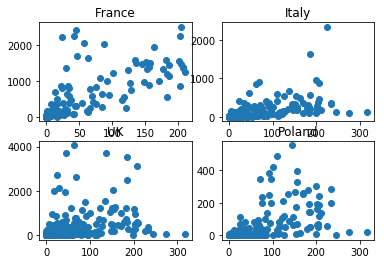

In [53]:
from datetime import timedelta

countries=['France','Italy','UK','Poland']
lag=0
d=datetime.timedelta(weeks=lag)

plt.subplot(221)
plt.scatter(df_inf_per_state.loc[(df_inf_per_state.index.min()+d):,'Germany'], df_inf_per_state.loc[:(df_inf_per_state.index.max()-d),countries[0]])
plt.title(countries[0])

plt.subplot(222)
plt.scatter(df_inf_per_state.loc[(df_inf_per_state.index.min()+d):,'Germany'], df_inf_per_state.loc[:(df_inf_per_state.index.max()-d),countries[1]])
plt.title(countries[1])

plt.subplot(223)
plt.scatter(df_inf_per_state.loc[(df_inf_per_state.index.min()+d):,'Germany'], df_inf_per_state.loc[:(df_inf_per_state.index.max()-d),countries[2]])
plt.title(countries[2])

plt.subplot(224)
plt.scatter(df_inf_per_state.loc[(df_inf_per_state.index.min()+d):,'Germany'], df_inf_per_state.loc[:(df_inf_per_state.index.max()-d),countries[3]])
plt.title(countries[3])


EDATE
2000-01-09    455.0
2000-01-16    383.0
2000-01-23    366.0
2000-01-30    196.0
2000-02-06     97.0
2000-02-13     50.0
2000-02-20     36.0
2000-02-27     24.0
2000-03-05      3.0
2000-03-12      5.0
2000-03-19      4.0
2000-03-26      1.0
2000-04-02      1.0
2000-04-09      3.0
2000-04-16      NaN
2000-04-23      NaN
2000-04-30      NaN
2000-05-07      NaN
2000-05-14      NaN
2000-05-21      NaN
2000-05-28      NaN
2000-06-04      NaN
2000-06-11      NaN
2000-06-18      NaN
2000-06-25      NaN
2000-07-02      NaN
2000-07-09      NaN
2000-07-16      NaN
2000-07-23      NaN
2000-07-30      NaN
              ...  
2017-07-23      0.0
2017-07-30      0.0
2017-08-06      1.0
2017-08-13      0.0
2017-08-20      0.0
2017-08-27      0.0
2017-09-03      0.0
2017-09-10      0.0
2017-09-17      0.0
2017-09-24      0.0
2017-10-01      NaN
2017-10-08      3.0
2017-10-15      5.0
2017-10-22      2.0
2017-10-29      0.0
2017-11-05      2.0
2017-11-12      3.0
2017-11-19      2.0
2017-11-26    

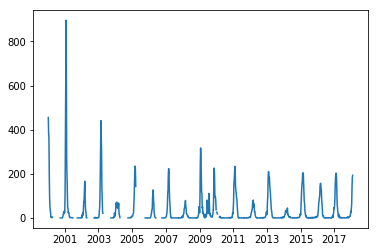

In [8]:
import numpy as np
from scipy import stats

x=df_inf_per_state.index.values
y=df_inf_per_state['Germany'].as_matrix()
not_nan_ind = ~np.isnan(y)
#m, b, r_val, p_val, std_err = stats.linregress(x[not_nan_ind],y[not_nan_ind])
#detrend_y = y - (m*x + b)
plt.plot(x,y)

df_inf_per_state['Germany']

In [54]:
#detrending the data

from scipy import signal

df_inf_per_state_detr=pd.DataFrame()

x=df_inf_per_state.index.values

for column in df_inf_per_state:
    #df_inf_per_state_detr[column] = signal.detrend(df_inf_per_state[column])
    y=df_inf_per_state[column]
    not_nan_ind = ~np.isnan(y)
    m, b, r_val, p_val, std_err = stats.linregress(x[not_nan_ind],y[not_nan_ind])
    detrend_y = y - (m*x + b)


signal.detrend(x)

NameError: name 'np' is not defined

## Cross-correlation of influenza cases reported from German states


In the following, the cross-correlation of the influenza cases reported in Bavaria and in other states in Garmeny is investigated for different time-lags, that may indicate the delay of the flu wave between the states. 


In [55]:
#settings:

#time lags (in weeks) for calculating the cross-correlation
timelag=range(-5,10,1)

#cutoff year (from which year the analysis should be done)
cutoff=datetime.datetime(2000,1,1)
df_RKI_states=df_RKI_states.loc[cutoff:]
df_RKI_states.head()


,Germany_sum,Baden-Wuerttemberg,Bavaria,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Mecklenburg-Vorpommern,Lower Saxony,North Rhine-Westphalia,Rhineland-Palatinate,Saarland,Saxony,Saxony-Anhalt,Schleswig-Holstein,Thuringia,Unknown
enddate,,,,,,,,,,,,,,,,,,
2001-01-07,7.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2001-01-14,15.0,0.0,0.0,1.0,2.0,0.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2001-01-21,55.0,1.0,4.0,0.0,10.0,0.0,0.0,0.0,6.0,2.0,9.0,2.0,0.0,13.0,2.0,3.0,3.0,0.0
2001-01-28,187.0,27.0,7.0,0.0,14.0,0.0,1.0,0.0,22.0,13.0,21.0,3.0,0.0,65.0,0.0,10.0,4.0,0.0
2001-02-04,460.0,63.0,32.0,59.0,40.0,0.0,3.0,7.0,24.0,42.0,13.0,4.0,0.0,138.0,17.0,2.0,16.0,0.0


In [56]:
column

'Albania'

In [57]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))   #pandas.Series.corr (Pearson correlation coefficient)


df_crosscorrDE=pd.DataFrame(index=timelag)
df_crosscorrDE_summary=pd.DataFrame(index=['max', 'shift [w]'])

for column in df_RKI_states:
    xcov_weekly = [crosscorr(df_RKI_states['Bavaria'],df_RKI_states[column], lag=i) for i in timelag]
    df_crosscorrDE[column] = xcov_weekly
    df_crosscorrDE_summary[column]=[max(xcov_weekly), timelag[xcov_weekly.index(max(xcov_weekly))]]
 

df_crosscorrDE_summary

,Germany_sum,Baden-Wuerttemberg,Bavaria,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Mecklenburg-Vorpommern,Lower Saxony,North Rhine-Westphalia,Rhineland-Palatinate,Saarland,Saxony,Saxony-Anhalt,Schleswig-Holstein,Thuringia,Unknown
max,0.963596,0.935987,1.0,0.886412,0.837059,0.757793,0.863888,0.932764,0.78603,0.868501,0.86036,0.930879,0.861642,0.823663,0.868402,0.916082,0.860269,0.668417
shift [w],-1.000000,0.000000,0.0,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.00000,-1.000000,-1.00000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


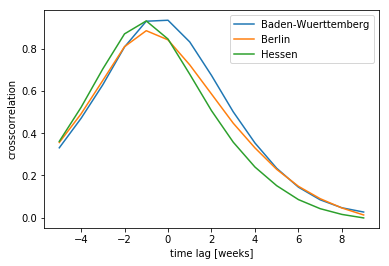

In [58]:
#plt.plot(timelag, df_crosscorr['France'])
df_crosscorrDE.reset_index().plot(x='index', y=['Baden-Wuerttemberg', 'Berlin', 'Hessen'])
plt.xlabel('time lag [weeks]')
plt.ylabel('crosscorrelation')
plt.legend()
plt.show()

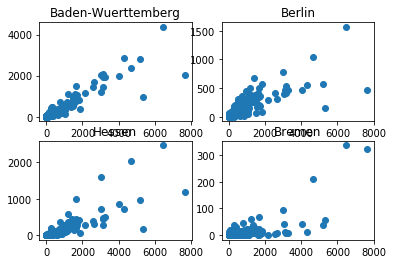

In [59]:
from datetime import timedelta

countries=['Baden-Wuerttemberg', 'Berlin', 'Hessen','Bremen']
lag=-1
d=datetime.timedelta(weeks=lag)

plt.subplot(221)
plt.scatter(df_RKI_states.loc[(df_RKI_states.index.min()+d):,'Bavaria'], df_RKI_states.loc[:(df_RKI_states.index.max()-d),countries[0]])
plt.title(countries[0])

plt.subplot(222)
plt.scatter(df_RKI_states.loc[(df_RKI_states.index.min()+d):,'Bavaria'], df_RKI_states.loc[:(df_RKI_states.index.max()-d),countries[1]])
plt.title(countries[1])

plt.subplot(223)
plt.scatter(df_RKI_states.loc[(df_RKI_states.index.min()+d):,'Bavaria'], df_RKI_states.loc[:(df_RKI_states.index.max()-d),countries[2]])
plt.title(countries[2])

plt.subplot(224)
plt.scatter(df_RKI_states.loc[(df_RKI_states.index.min()+d):,'Bavaria'], df_RKI_states.loc[:(df_RKI_states.index.max()-d),countries[3]])
plt.title(countries[3])
 

# Google trend data

Google trend data is expected to give a good estimator of the current influenza situation in a country. It's quality for medium and long term are questionable. 

## Comparison Germany Bavaria (Saarland)

The google trend timeseries (keyword Influenza) from Germany and Bavaria (and Saarland) are superimposed to check wether different characteristics regarding initiation time/magnitude etc. can be observed.

In [60]:
# get data through the unofficial Google treds API (pytrends)
import pandas as pd
from pytrends.request import TrendReq
pytrends = TrendReq(hl = 'en-US')

kw_list = ["Influenza"]
timeframe_idx = 'today 5-y' # weekly stats for last 5 years (all givels everyting starting from 2004 but at monthly resolution)
cat_idx_Gesundheit = 45
geo_idx = 'DE'
geo_idxBY = 'DE-BY'
geo_idxSL = 'DE-SL'

pytrends.build_payload(kw_list,cat=cat_idx_Gesundheit,timeframe = timeframe_idx,geo = geo_idx)
pf_googleTrends_Germany = pytrends.interest_over_time()
pf_googleTrends_Germany.rename(columns={'Influenza':'Germany'})

pytrends.build_payload(kw_list,cat=cat_idx_Gesundheit,timeframe = timeframe_idx,geo = geo_idxBY)
pf_googleTrends_Bavaria = pytrends.interest_over_time()
pf_googleTrends_Bavaria.rename(columns={'Influenza':'Bavaria'})

pytrends.build_payload(kw_list,cat=cat_idx_Gesundheit,timeframe = timeframe_idx,geo = geo_idxSL)
pf_googleTrends_Saarland = pytrends.interest_over_time()
pf_googleTrends_Saarland.rename(columns={'Influenza':'Saarland'})

pf_googleTrends_EU = pf_googleTrends_Germany
pf_googleTrends_EU = pf_googleTrends_EU.rename(columns = {'Influenza':'Germany'})

EUcountries = {'Belgium':'BE','Bulgaria':'BG','Czech Republic':'CZ','Denmark':'DK','Estonia':'EE','Ireland':'IE','Greece':'GR','Spain':'ES','France':'FR','Croatia':'HR','Italy':'IT','Cyprus':'CY','Latvia':'LV','Lithuania':'LT','Luxembourg':'LU','Hungary':'HU','Netherlands':'NL','Austria':'AT','Poland':'PL','Portugal':'PT','Romania':'RO','Slovenia':'SI','Slovakia':'SK','Finland':'FI','Sweden':'SE','UK':'GB'}#,'Malta':'MT'}
Influenza_dictionary = {'Belgium':['Influenza'],'Bulgaria':['грип'],'Czech Republic':['chřipka'],'Denmark':['Influenza'],'Estonia':['gripp'],'Ireland':['influenza'],'Greece':['γρίπη'],'Spain':['influenza '],'France':['influenza '],'Croatia':['influenca'],'Italy':['influenza'],'Cyprus':['γρίπη'],'Latvia':'gripa','Lithuania':['gripą'],'Luxembourg':['influenza'],'Hungary':['influenza'],'Netherlands':['influenza'],'Austria':['Influenza'],'Poland':['grypa'],'Portugal':['influenza'],'Romania':['gripă'],'Slovenia':['gripe'],'Slovakia':['chrípka'],'Finland':['influenssa'],'Sweden':['influensa'],'UK':['influenza']}#,'Malta':['influwenza']}



for country_key in EUcountries.keys():
    print(country_key)
    kw_list = Influenza_dictionary[country_key]
    pytrends.build_payload(kw_list,cat=cat_idx_Gesundheit,timeframe = timeframe_idx,geo = EUcountries[country_key])
    temp_df = pytrends.interest_over_time().drop(columns = 'isPartial')
    temp_df = temp_df.rename(columns = {kw_list[0]:country_key})
    pf_googleTrends_EU = pf_googleTrends_EU.join(temp_df,rsuffix = EUcountries[country_key])



Italy
Czech Republic


/usr/local/Cellar/matplotlib/2.0.2/libexec/lib/python2.7/site-packages/dateutil/parser.py:98: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  while nextchar == '\x00':
/usr/local/Cellar/matplotlib/2.0.2/libexec/lib/python2.7/site-packages/dateutil/parser.py:123: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif nextchar == '.':


Lithuania
Luxembourg
France
Slovakia
Ireland
Slovenia
Belgium
Spain
Netherlands
Denmark
Poland
Finland
Sweden
Latvia
Croatia
Bulgaria
Romania
Estonia
Portugal
Austria
UK
Greece


/usr/local/lib/python2.7/site-packages/pandas/core/indexes/base.py:1318: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.is_unique


Hungary
Cyprus


In [61]:
pf_googleTrends_EU.tail(22)

,Germany,isPartial,Italy,Czech Republic,Lithuania,Luxembourg,France,Slovakia,Ireland,Slovenia,...,Croatia,Bulgaria,Romania,Estonia,Portugal,Austria,UK,Greece,Hungary,Cyprus
date,,,,,,,,,,,,,,,,,,,,,
2017-09-24,6,False,13,16,0,0,37,26,4,0,...,0,11,16,0,0,7,31,9,5,0
2017-10-01,5,False,13,19,0,0,14,4,18,0,...,0,18,16,14,13,4,32,0,5,0
2017-10-08,8,False,13,10,0,0,45,17,29,0,...,0,16,30,27,13,7,30,0,8,22
2017-10-15,6,False,12,15,0,0,18,8,14,0,...,0,14,0,0,51,7,24,0,8,0
2017-10-22,7,False,11,9,0,0,69,8,7,10,...,0,8,0,0,13,4,23,0,14,0
2017-10-29,6,False,12,10,0,0,37,0,11,11,...,0,9,15,0,39,6,30,0,10,0
2017-11-05,5,False,17,12,0,11,54,4,21,0,...,0,10,14,0,0,4,29,10,13,0
2017-11-12,8,False,14,8,0,0,40,15,4,0,...,0,6,0,0,65,4,36,28,11,0
2017-11-19,7,False,14,12,0,0,22,11,7,9,...,0,6,14,53,38,11,25,0,17,0


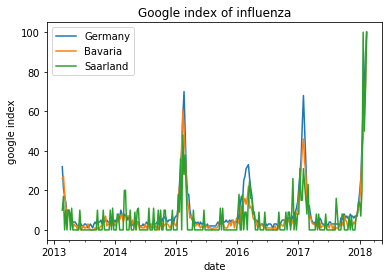

In [62]:
fig = plt.figure()
ax = pf_googleTrends_Germany.plot()
pf_googleTrends_Bavaria.plot(ax = ax)
pf_googleTrends_Saarland.plot(ax = ax)

plt.title('Google index of influenza')
plt.xlabel('date')
plt.ylabel('google index')
ax.legend(['Germany','Bavaria','Saarland'])





## Autocorrelation Germany

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 60)

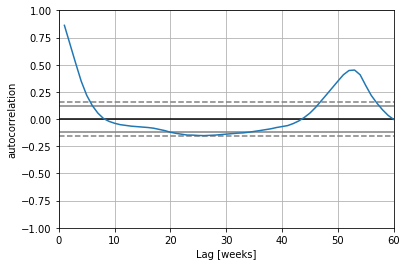

In [63]:
from pandas.tools.plotting import autocorrelation_plot
fig = plt.figure()
autocorrelation_plot(pf_googleTrends_Germany['Influenza'])
plt.xlabel('Lag [weeks]')
plt.ylabel('autocorrelation')
plt.xlim([0,60])

## Cross-correlation of influenza cases reported from European countries with Google trend data

In [64]:
# get worldwide google Influenza trends 
# get data through the unofficial Google treds API (pytrends)


In [65]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))   #pandas.Series.corr (Pearson correlation coefficient)


timelag=range(-5,10,1)

df_crosscorr_google=pd.DataFrame(index=timelag)
df_crosscorr_google_summary=pd.DataFrame(index=['max', 'shift [w]'])

for column in EUcountries.keys():
    xcov_weekly = [crosscorr(pf_googleTrends_EU['Germany'],pf_googleTrends_EU[column], lag=i) for i in timelag]
    df_crosscorr_google[column] = xcov_weekly
    df_crosscorr_google_summary[column]=[max(xcov_weekly), timelag[xcov_weekly.index(max(xcov_weekly))]]
 

df_crosscorr_google_summary.loc[:,EUcountries.keys()]#['Italy','Austria','UK', 'Switzerland','France', 'Spain', 'Poland', 'Netherlands', 'Sweden']]


,Italy,Czech Republic,Lithuania,Luxembourg,France,Slovakia,Ireland,Slovenia,Belgium,Spain,...,Croatia,Bulgaria,Romania,Estonia,Portugal,Austria,UK,Greece,Hungary,Cyprus
max,0.902937,0.734958,0.358077,0.598709,0.575316,0.689482,0.656604,0.616821,0.586419,0.534779,...,0.315946,0.733746,0.571226,0.537629,0.438529,0.876468,0.730095,0.401576,0.87247,0.152973
shift [w],5.000000,2.000000,3.000000,0.000000,4.000000,1.000000,5.000000,3.000000,1.000000,4.000000,...,3.000000,4.000000,0.000000,0.000000,5.000000,2.000000,4.000000,1.000000,1.00000,5.000000


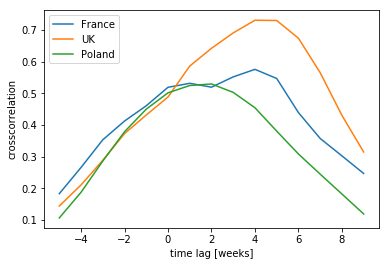

In [66]:
df_crosscorr_google.reset_index().plot(x='index', y=['France', 'UK', 'Poland'])
plt.xlabel('time lag [weeks]')
plt.ylabel('crosscorrelation')
plt.legend()
plt.show()


## Comparison of magnitude between different countries
To use the data from other countries for prediction of the magnitude of the flu wave in Germany there needs to be a clear relationship between the magnitudes of the flu waves (here in terms of google search index) in the different countries.

(2401, 2513)

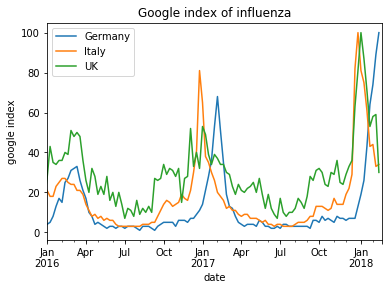

In [67]:
fig = plt.figure()

countries = ['Germany','Italy','UK']#,'France','Poland']

for country in countries:
    ax_google = pf_googleTrends_EU[country].plot()
    pf_googleTrends_EU[country].plot(ax = ax)


plt.title('Google index of influenza')
plt.xlabel('date')
plt.ylabel('google index')
ax_google.legend(countries)
plt.xlim([datetime.date(year=2016,month=1,day=1),datetime.date.today()])





# Heatmaps

Heatmap created following: http://www.alexschultz.co.uk/weblog/2010/07/creating-country-level-heatmaps-in-python.html

In [68]:
os.getcwd()


NameError: name 'os' is not defined

In [ ]:
from lxml import etree
import os

def show_flu_inEU_for_week_lxml(date): 
    # date is a datetime object
    # soup a beatiful soup object
    currnt_dir = os.getcwd()
    os.chdir(currnt_dir)
    svg = etree.parse('Blank_map_of_Europe_cropped.svg')
    EUcountries = {'Belgium':'BE','Bulgaria':'BG','Czech Republic':'CZ','Denmark':'DK','Estonia':'EE','Ireland':'IE','Greece':'GR','Spain':'ES','France':'FR','Croatia':'HR','Italy':'IT','Cyprus':'CY','Latvia':'LV','Lithuania':'LT','Luxembourg':'LU','Hungary':'HU','Netherlands':'NL','Austria':'AT','Poland':'PL','Portugal':'PT','Romania':'RO','Slovenia':'SI','Slovakia':'SK','Finland':'FI','Sweden':'SE','UK':'GB'}#,'Malta':'MT'}
    map_countryCode = {'lt-3': 'Lithuania', 'gb-gbn-5': 'UK', 'lv-1': 'Latvia', 'fi-5': 'Finland', 'sk-2': 'Slovakia', 'lu-7': 'Luxembourg', 'si-9': 'Slovenia', 'at-3': 'Austria', 'ie-5': 'Ireland', 'dk-9': 'Denmark', 'be-2': 'Belgium', 'gr-7': 'Greece', 'ee-8': 'Estonia', 'es-4': 'Spain', 'cz-1': 'Czech Republic', 'ro-1': 'Romania', 'hu-3': 'Hungary', 'nl-3': 'Netherlands', 'hr-2': 'Croatia', 'it-4': 'Italy', 'cy-6': 'Cyprus', 'fr-7': 'France', 'pt-0': 'Portugal', 'se-7': 'Sweden', 'de-2': 'Germany', 'bg-3': 'Bulgaria', 'pl-1': 'Poland'}#, 'mt-0': 'Malta'}
#    map_countryCode = {'lt': 'Lithuania', 'gb': 'UK', 'lv': 'Latvia', 'fi': 'Finland', 'sk': 'Slovakia', 'lu': 'Luxembourg', 'si': 'Slovenia', 'at': 'Austria', 'ie': 'Ireland', 'dk': 'Denmark', 'be': 'Belgium', 'gr': 'Greece', 'va': 'Vatican', 'ee': 'Estonia', 'es': 'Spain', 'cz': 'Czech Republic', 'ro': 'Romania', 'mt': 'Malta', 'hu': 'Hungary', 'nl': 'Netherlands', 'hr': 'Croatia', 'it': 'Italy', 'cy': 'Cyprus', 'fr': 'France', 'pt': 'Portugal', 'se': 'Sweden', 'de': 'Germany', 'bg': 'Bulgaria', 'pl': 'Poland'}
    
    path_style ="stroke:#ffffff;stroke-width:0.40082097;stroke-miterlimit:4;stroke-dasharray:none;fill:" 
    #path_style = "fill-opacity:1;stroke:#ffffff;stroke-width:0.5225144" 
    colormap = ["#c0c0c0","#ffeda0","#feb24c","#f03b20"]

    pf_of_date = pf_googleTrends_EU.ix[date]
    root = svg.getroot()
    child_element = root.find('{http://www.w3.org/2000/svg}g')
    # countries with multiple polygons
    gs = child_element.findall('{http://www.w3.org/2000/svg}g')
    
    # countries without multiple polygons
    paths = child_element.findall('{http://www.w3.org/2000/svg}path')
    
    for p in paths:
        p_id = p.get('id')
        
        if p_id in map_countryCode.keys():
            if pf_of_date[map_countryCode[p_id]] > 50:
                color_class = 3
            elif pf_of_date[map_countryCode[p_id]] > 10:
                color_class = 2               
            elif pf_of_date[map_countryCode[p_id]] > 1:
                color_class = 1                  
            else:
                color_class = 0
              
            color = colormap[color_class]
            p.set('style', path_style + color)
            
            
            
    for g in gs:
        g_id = g.get('id')
        if g_id in map_countryCode.keys():        
            if pf_of_date[map_countryCode[g_id]] > 50:
                color_class = 3
            elif pf_of_date[map_countryCode[g_id]] > 10:
                color_class = 2
            elif pf_of_date[map_countryCode[g_id]] > 1:
                color_class = 1
            else:
                color_class = 0
            color = colormap[color_class]  
            
            for t in g.findall('{http://www.w3.org/2000/svg}path'):
                t.set('style',path_style+color)
            for g_3rdlevel in g.findall('{http://www.w3.org/2000/svg}g'):
                for t2 in g_3rdlevel.findall('{http://www.w3.org/2000/svg}path'):
                    t.set('style',path_style+color)
                
    # write everything to a file
    f = svg.write('EU_flu_'+ date.strftime('%Y_%m_%d')+'.svg',pretty_print = True)            
                        
        

In [ ]:
startdate = datetime.datetime.strptime('2017-07-30','%Y-%m-%d')
time_steps = 12
time_delta = 14 #days

for i in xrange(0,time_steps):
    date = startdate + timedelta(days= i*time_delta)
    show_flu_inEU_for_week_lxml(date)


new cell